In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
import time
import os
from color_regions import ColorDatasetGenerator
import colorsys
import matplotlib.pyplot as plt
torch.backends.cudnn.benchmark = True
device = "cuda:0" if torch.cuda.is_available() else "cpu"

/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/rob/Data2/jackpytorch/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warn(f"Failed to load image Python extension: {e}")


In [2]:
import sys
prev_time = 0
gamma = 0.99
stats = {}  # tracks ewma running average
def benchmark(point=None, profile=True, verbose=True, cuda=True): # not thread safe at all
    global prev_time
    if not profile:
        return
    if cuda:
        torch.cuda.synchronize()
    time_now = time.perf_counter()
    if point is not None:
        point = f"{sys._getframe().f_back.f_code.co_name}-{point}"
        time_taken = time_now - prev_time
        if point not in stats:
            stats[point] = time_taken
        stats[point] = stats[point]*gamma + time_taken*(1-gamma)
        if verbose:
            print(f"took {time_taken} to reach {point}, ewma={stats[point]}")
    prev_time = time_now

In [3]:
transform = transforms.Compose(
     [transforms.ToTensor()])#,
    #transforms.Normalize((0.5), (0.5))])

batch_size = 32  # seems to be the fastest batch size
train_indices = (0, 200_000) # size of training set
valid_indices = (1_250_000, 1_260_000)
test_indices = (260_000, 270_000)

def color_classifier(color):
    hue = colorsys.rgb_to_hsv(*(color[0]/255))[0]*360.
    if hue <= 20:  # => 3 classes
        return 0
    if 20 < hue <= 40: 
        return 3
    if 40 < hue <= 60:
        return 1
    if 60 < hue <= 80:
        return 0
    if 80 < hue <= 120:
        return 2
    if 120 < hue <= 160:
        return 1
    if 160 < hue <= 200:
        return 0
    if 200 < hue <= 240:
        return 1
    if 240 < hue:# <= 280:
        return 3
#     if 280 < hue <= 310:
#         return 4
#     if 310 < hue <= 325:
#         return 2
#     if 325 < hue <= 340:
#         return 1
#     if 340 < hue:
#         return 0
critical_color_values = [x/255.*360. for x in [20, 40, 60, 80, 120, 160, 200, 240]]
# weird critical values since i messed up the initial color_classifier, as i multiplied the 
# rgb_to_hsv values by 255. instead of 360 to be in the good range for hue

def set_loader_helper(indices):
    data_set = ColorDatasetGenerator(color_classifier=color_classifier,
                                    image_indices=indices,
                                    transform=transform,
                                    num_classes=4,
                                    channels=3,
                                    bg_color=np.array([127., 127., 127.]),
                                    noise_size=(5,15),
                                    size=128,
                                    radius=(128//6, 128//3))
    loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size, 
                                          shuffle=True, num_workers=4, pin_memory=True)
    return data_set, loader
train_set, train_loader = set_loader_helper(train_indices)
valid_set, valid_loader = set_loader_helper(valid_indices)
test_set, test_loader = set_loader_helper(test_indices)

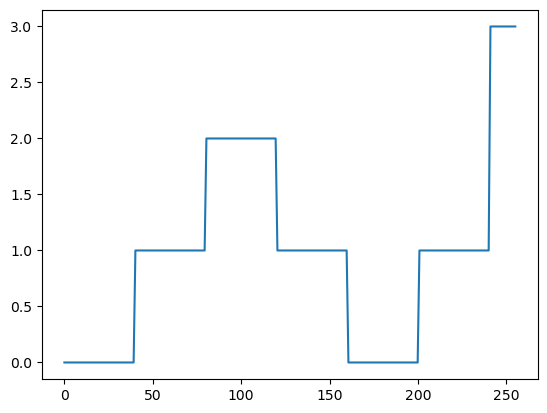

In [4]:
# the "hard" task
color_probe = np.linspace(0, 255, 255)
color_class = [color_classifier(x) for x in color_probe]
plt.plot(color_probe, color_class)

In [4]:
class ResNet(nn.Module):
    def __init__(self, conv_layers, num_classes, img_shape, path, groups=1):
        super().__init__()
        self.conv_layers1 = []  # entry into residual block 
        self.conv_layers2 = []  # https://arxiv.org/pdf/1512.03385.pdf Figure 3
        self.batch_norms1 = []
        self.batch_norms2 = []
        self.is_resid = []
        self.path = path
        self.num_classes = num_classes
        #self.shift = nn.Parameter(1)  # TODO: maybe add this (or just do an initial batchnorm)
        #self.scale = nn.Parameter(1)
        channels = img_shape[-1]
        img_size = img_shape[0]
        for l in conv_layers:  # (out_channels, kernel_size, stride) is each l
            if l[2] == 2: # stride
                pad_type = "valid"
                img_size = (img_size-l[1])//l[2] + 1 # https://arxiv.org/pdf/1603.07285.pdf
            else:
                pad_type = "same"
            if isinstance(l[0], float):
                l[0] = int(l[0])
                l[0] -= l[0] % groups # ensure divisble by groups
            self.is_resid.append(l[2] == 1 and channels == l[0])
            self.conv_layers1.append(nn.Conv2d(channels, l[0], l[1], stride=l[2], padding=pad_type, groups=groups))
            channels = l[0]
            self.final_num_logits = channels * img_size * img_size 
            self.batch_norms1.append(nn.BatchNorm2d(channels)) # cant use track_running_stats=False since
            self.batch_norms2.append(nn.BatchNorm2d(channels)) # it causes poor performance for inference with batch size=1 (or probably with the same image repeated a bunch of times)
            self.conv_layers2.append(nn.Conv2d(channels, channels, l[1], padding=pad_type, groups=groups))
        self.conv_layers1 = nn.ModuleList(self.conv_layers1)
        self.conv_layers2 = nn.ModuleList(self.conv_layers1)
        self.batch_norms1 = nn.ModuleList(self.batch_norms1)
        self.batch_norms2 = nn.ModuleList(self.batch_norms2)

        self.fully_connected1 = nn.Linear(self.final_num_logits, 1000)
        self.fully_connected2 = nn.Linear(1000, num_classes)

    def forward(self, x, logits=False, profile=False):
        benchmark(profile=profile)
        network_iter = zip(self.conv_layers1, self.conv_layers2, self.batch_norms1, self.batch_norms2, self.is_resid)
        benchmark("iter create", profile=profile, verbose=False)
        for i, (conv1, conv2, batch_norm1, batch_norm2, is_resid) in enumerate(network_iter):
            x_conv1 = F.relu(batch_norm1(conv1(x)))
            benchmark(f"conv_bn_relu {i}+1", profile=profile, verbose=False)
            x_conv2 = F.relu(batch_norm2(conv2(x)))
            benchmark(f"conv_bn_relu {i}+2", profile=profile, verbose=False)
            if is_resid:
                x = x + x_conv2  # residual block
            else:
                x = x_conv2  # dimension increasing block
            benchmark(f"is_resid {i}", profile=profile, verbose=False)
        x = torch.flatten(x, 1)
        benchmark(f"flatten", profile=profile, verbose=False)
        x = F.relu(self.fully_connected1(x))
        benchmark(f"relu fc 1", profile=profile, verbose=False)
        x = self.fully_connected2(x)
        benchmark(f"relu fc 2", profile=profile, verbose=False)
        if self.num_classes == 1 and not logits:  # always allow returning logits
            x = torch.sigmoid(x)
        benchmark(f"final", profile=profile, verbose=False)
        return x    

    def num_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
    
    def save_model_state_dict(self, path=None, optim=None):
        if path is None:
            path = self.path
        if optim is not None:
            save_dict = {}
            save_dict["model"] = self.state_dict()
            save_dict["optim"] = optim.state_dict()
        else:
            save_dict = self.state_dict()
        torch.save(save_dict, path)
    
    def load_model_state_dict(self, path=None, optim=None):
        if path is None:
            path = self.path
        if not os.path.exists(path):
            return
        load_dict = torch.load(path)
        if "model" in load_dict:
            if optim is not None:
                optim.load_state_dict(load_dict["optim"]) 
            self.load_state_dict(load_dict["model"])
        else:
            self.load_state_dict(load_dict)

In [5]:
def correct(pred_logits, labels):
    if labels.shape[1] != 1:
        pred_probabilities = F.softmax(pred_logits, dim=1)
        classifications = torch.argmax(pred_probabilities, dim=1)
        labels_argmax = torch.argmax(labels, dim=1)
    else:
        classifications = pred_logits.int()
        labels_argmax = labels
    correct = (labels_argmax == classifications)
    return correct

def train(net, optimizer, loss, epochs):
    va_losses = []
    tr_losses = []
    va_accuracies = []
    for epoch in range(epochs):
        net.save_model_state_dict(optim=optimizer)
        epoch_tr_loss = 0.0
        net.train()
        for i, sample in tqdm(enumerate(train_loader)):
            imgs = sample["image"].to(device, non_blocking=False).float()
            labels = sample["label"].to(device).float()
            optimizer.zero_grad()
            outputs = net(imgs)
            batch_loss = loss(outputs, labels)
            epoch_tr_loss += batch_loss.item()
            batch_loss.backward()
            optimizer.step()
        epoch_va_loss = 0.0
        epoch_va_correct = 0
        net.eval()
        with torch.no_grad():
            for i, sample in enumerate(valid_loader):
                imgs = sample["image"].to(device).float()
                labels = sample["label"].to(device).float()
                outputs = net(imgs)
                epoch_va_loss += loss(outputs, labels).item()
                epoch_va_correct += correct(outputs, labels).sum().item()
        epoch_va_accuracy = epoch_va_correct/(valid_indices[1] - valid_indices[0])
        print(f'Epoch {epoch + 1}: va_loss: {epoch_va_loss}, va_accuracy: {epoch_va_accuracy}, tr_loss: {epoch_tr_loss}')
        va_losses.append(epoch_va_loss)
        tr_losses.append(epoch_tr_loss)
        va_accuracies.append(epoch_va_accuracy)
    return va_losses, va_accuracies, tr_losses

In [6]:
res_net = ResNet([[64, 7, 1],  # num_channels (input and output), kernel_size, stride
                  [64, 3, 1],
                  [128, 3, 2],
                  [128, 3, 1],
                  [128, 3, 2],
                  [128, 3, 1],
                  [256, 3, 2],
                  [256, 3, 1],
                  [256, 3, 1],
                  [256, 3, 2],
                  [512, 3, 1],
                  [512, 3, 2],
                  [512, 3, 1]], 4, [128, 128, 3], "hard_color_fast_no_norm.dict").to(device)
loss_func = nn.CrossEntropyLoss()
optim = torch.optim.Adam(res_net.parameters())
print(res_net.num_params())
res_net.load_model_state_dict(optim=optim)

13153996


In [47]:
results = train(res_net, optim, loss_func, 200)

6250it [10:48,  9.63it/s]


Epoch 1: va_loss: 70.96838853508234, va_accuracy: 0.9095, tr_loss: 2684.4554074145854


6250it [10:52,  9.57it/s]


Epoch 2: va_loss: 126.81304313987494, va_accuracy: 0.8548, tr_loss: 1234.1132723679766


6250it [10:53,  9.57it/s]


Epoch 3: va_loss: 33.20257103070617, va_accuracy: 0.954, tr_loss: 898.9320826306939


6250it [10:53,  9.57it/s]


Epoch 4: va_loss: 56.662241134792566, va_accuracy: 0.9247, tr_loss: 706.597733102506


6250it [10:52,  9.58it/s]


Epoch 5: va_loss: 93.21853013709188, va_accuracy: 0.9021, tr_loss: 601.4892114514951


6250it [10:52,  9.57it/s]


Epoch 6: va_loss: 23.92419863352552, va_accuracy: 0.9701, tr_loss: 536.607637814479


6250it [10:52,  9.57it/s]


Epoch 7: va_loss: 40.90046150609851, va_accuracy: 0.9516, tr_loss: 494.2736585107632


6250it [10:52,  9.58it/s]


Epoch 8: va_loss: 17.489647837006487, va_accuracy: 0.9772, tr_loss: 447.8122839138232


6250it [10:52,  9.58it/s]


Epoch 9: va_loss: 13.950375005486421, va_accuracy: 0.9831, tr_loss: 417.7481189912214


6250it [10:52,  9.58it/s]


Epoch 10: va_loss: 48.13175037270412, va_accuracy: 0.95, tr_loss: 387.5429645305994


6250it [10:52,  9.57it/s]


Epoch 11: va_loss: 16.541079125709075, va_accuracy: 0.9752, tr_loss: 390.4348968111153


6250it [10:52,  9.58it/s]


Epoch 12: va_loss: 18.041026283055544, va_accuracy: 0.9761, tr_loss: 346.55587888331684


6250it [10:52,  9.58it/s]


Epoch 13: va_loss: 327.18913170695305, va_accuracy: 0.7614, tr_loss: 353.5688685471614


6250it [10:52,  9.58it/s]


Epoch 14: va_loss: 8.581208101721131, va_accuracy: 0.989, tr_loss: 321.5251496390156


6250it [10:52,  9.58it/s]


Epoch 15: va_loss: 11.76547525713795, va_accuracy: 0.9844, tr_loss: 319.17855770181177


6250it [10:52,  9.58it/s]


Epoch 16: va_loss: 10.290944270447653, va_accuracy: 0.9866, tr_loss: 312.732743902322


6250it [10:52,  9.58it/s]


Epoch 17: va_loss: 15.623192800605466, va_accuracy: 0.9821, tr_loss: 287.4835056336633


6250it [10:52,  9.58it/s]


Epoch 18: va_loss: 14.619984325778205, va_accuracy: 0.9786, tr_loss: 328.43429849121276


6250it [10:52,  9.58it/s]


Epoch 19: va_loss: 15.101949566502299, va_accuracy: 0.9773, tr_loss: 258.9472930358352


6250it [10:51,  9.59it/s]


Epoch 20: va_loss: 14.765110312378965, va_accuracy: 0.9816, tr_loss: 258.7757919278047


6250it [10:52,  9.58it/s]


Epoch 21: va_loss: 6.081330974013781, va_accuracy: 0.992, tr_loss: 249.18701781795153


6250it [10:52,  9.58it/s]


Epoch 22: va_loss: 8.282578774329522, va_accuracy: 0.9892, tr_loss: 252.30327364284904


6250it [10:52,  9.58it/s]


Epoch 23: va_loss: 9.51798294951459, va_accuracy: 0.9882, tr_loss: 226.8810714893134


6250it [10:52,  9.58it/s]


Epoch 24: va_loss: 7.008150701716659, va_accuracy: 0.9931, tr_loss: 218.02958666934683


6250it [10:52,  9.58it/s]


Epoch 25: va_loss: 12.794608879798034, va_accuracy: 0.9866, tr_loss: 199.903898121216


6250it [10:51,  9.59it/s]


Epoch 26: va_loss: 9.046185396226065, va_accuracy: 0.9879, tr_loss: 192.7455074771808


6250it [10:51,  9.59it/s]


Epoch 27: va_loss: 9.857081849988845, va_accuracy: 0.987, tr_loss: 183.09076001946084


6250it [10:51,  9.59it/s]


Epoch 28: va_loss: 6.250182067502465, va_accuracy: 0.9935, tr_loss: 179.32671492880684


6250it [10:52,  9.58it/s]


Epoch 29: va_loss: 10.058372905099532, va_accuracy: 0.9865, tr_loss: 180.95786049269503


6250it [10:51,  9.59it/s]


Epoch 30: va_loss: 4.232468366868034, va_accuracy: 0.9948, tr_loss: 144.30909849388897


6250it [10:51,  9.59it/s]


Epoch 31: va_loss: 8.306177423422923, va_accuracy: 0.9893, tr_loss: 151.31596498368154


6250it [10:51,  9.59it/s]


Epoch 32: va_loss: 4.186035859508593, va_accuracy: 0.9953, tr_loss: 148.03257453592073


6250it [10:51,  9.59it/s]


Epoch 33: va_loss: 6.46301491205395, va_accuracy: 0.9937, tr_loss: 126.58822765565426


6250it [10:51,  9.59it/s]


Epoch 34: va_loss: 7.892347685516825, va_accuracy: 0.9911, tr_loss: 119.45133208635451


6250it [10:51,  9.59it/s]


Epoch 35: va_loss: 5.397738823203923, va_accuracy: 0.9931, tr_loss: 115.30881798237837


6250it [10:52,  9.59it/s]


Epoch 36: va_loss: 2.8712630933209766, va_accuracy: 0.9968, tr_loss: 126.68415012748014


6250it [10:51,  9.59it/s]


Epoch 37: va_loss: 6.395224188858265, va_accuracy: 0.992, tr_loss: 101.87691643252992


6250it [10:51,  9.59it/s]


Epoch 38: va_loss: 4.780533972003923, va_accuracy: 0.9935, tr_loss: 99.70904355564998


6250it [10:51,  9.59it/s]


Epoch 39: va_loss: 2.717483413076252, va_accuracy: 0.997, tr_loss: 103.98783271069348


6250it [10:51,  9.59it/s]


Epoch 40: va_loss: 7.285338892214298, va_accuracy: 0.9917, tr_loss: 102.20961738716409


6250it [10:51,  9.59it/s]


Epoch 41: va_loss: 7.136886081431377, va_accuracy: 0.9916, tr_loss: 81.87059733655889


6250it [10:51,  9.59it/s]


Epoch 42: va_loss: 2.910695782828043, va_accuracy: 0.9965, tr_loss: 84.48423067977544


247it [00:25,  9.57it/s]


KeyboardInterrupt: 

In [27]:
@torch.no_grad()
def rate_distribution(net, loader, dataset, buckets=100):
    net.eval()
    total = np.zeros((buckets))
    num_correct = np.zeros((buckets))
    num_possible_colors = dataset.hue_range[1] - dataset.hue_range[0]
    for sample in tqdm(loader):
        imgs = sample["image"].to(device).float()
        labels = sample["label"].to(device).float()
        rgb_colors = sample["color"]
        hues = dataset.iterative_color_cvt("rgb_to_hsv", rgb_colors.squeeze()/255.)[:, 0]*360.
        color_indices = (buckets * (hues - dataset.hue_range[0]) / num_possible_colors).astype(np.int32)
        outputs = net(imgs)
        correct_preds = correct(outputs, labels).cpu().numpy()
        for i, color_idx in enumerate(color_indices):
            total[color_idx] += 1  
            num_correct[color_idx] += correct_preds[i]
    return num_correct, total
_num_correct, _total = rate_distribution(res_net, valid_loader, valid_set, buckets=360)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:15<00:00, 20.86it/s]


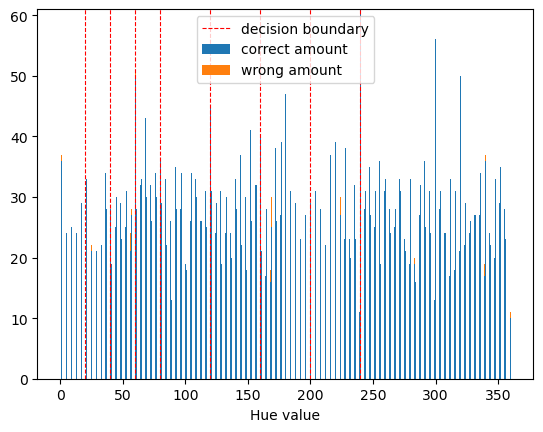

In [28]:
def make_graph(num_correct, total, dataset, critical_values=[150-0.5], buckets=100):
    num_wrong = total - num_correct
    width = 0.35
    labels = [int(x) for i, x in enumerate(np.linspace(*dataset.hue_range, buckets))]
    plt.bar(labels, num_correct, width, label="correct amount")
    plt.bar(labels, num_wrong, width, bottom=num_correct, label="wrong amount")
    plt.vlines(critical_values, 0, np.max(total), 
               linewidth=0.8, colors="r", label="decision boundary",
               linestyles="dashed")
    plt.legend()
    plt.xlabel("Hue value")
    plt.show()
make_graph(_num_correct, _total, valid_set,   # with .eval(), looks good
           critical_values=[x-0.5 for x in critical_color_values], buckets=360) 

In [55]:
res_net.eval() # very important!
with torch.no_grad():
    test_index = 987_652 
    counterfactual_color_values = np.linspace(0, 360, 360)/360.  # in [0, 1]
    responses = []
    np.random.seed(test_index)
    _, __, rgb_color = valid_set.generate_one()
    base_hsv = valid_set.iterative_color_cvt("rgb_to_hsv", rgb_color/255.)[0] # in [0, 1]
    for i, color in enumerate(counterfactual_color_values):
        base_hsv[0] = color # update hue to new value
        rgb_color = np.array([colorsys.hsv_to_rgb(*base_hsv)])[0] * 255.
        np.random.seed(test_index)
        generated_img, lbl, __ = valid_set.generate_one(set_color=rgb_color)
        generated_img = np.expand_dims(generated_img, 0).transpose(0, 3, 1, 2)
        generated_img = torch.tensor(generated_img).to(device).float()
        response = res_net(torch.tensor(generated_img).to(device).float(), logits=True).cpu().numpy()
        responses.append(np.squeeze(response))
#         if i % 50 == 0:
#             plt.imshow(generated_img.squeeze().cpu().numpy().transpose(1, 2, 0)/255.)
#             plt.show()
#             input()

/tmp/ipykernel_258700/2305014950.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  response = res_net(torch.tensor(generated_img).to(device).float(), logits=True).cpu().numpy()


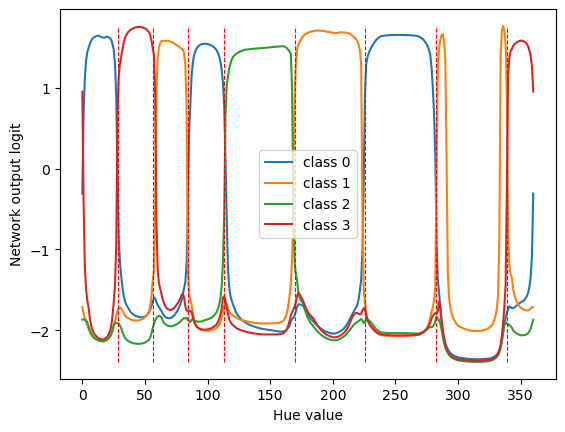

In [58]:
responses = np.arcsinh(np.array(responses))
for output_logit in range(responses.shape[1]):
    plt.plot(counterfactual_color_values*360., responses[:, output_logit], label=f"class {output_logit}")
plt.legend()
plt.xlabel("Hue value")
plt.ylabel("Network output logit")
plt.vlines(critical_color_values, np.min(responses), np.max(responses), linewidth=0.8,
           colors="r", label="decision boundary",
           linestyles="dashed") # with .eval() works well

In [13]:
res_net.eval() # very important!
with torch.no_grad():
    test_index = 987_652 
    counterfactual_color_values = np.linspace(0, 255, 255)  # in [0, 1]
    responses = []
    np.random.seed(test_index)
    _, __, rgb_color = valid_set.generate_one()
    rgb_color = rgb_color[0]
    for i, color in enumerate(counterfactual_color_values):
        rgb_color[0] = color # update red to new value
        np.random.seed(test_index)
        generated_img, lbl, __ = valid_set.generate_one(set_color=rgb_color)
        generated_img = np.expand_dims(generated_img, 0).transpose(0, 3, 1, 2)
        generated_img = torch.tensor(generated_img).to(device).float()
        response = res_net(torch.tensor(generated_img).to(device).float(), logits=True).cpu().numpy()
        responses.append(np.squeeze(response))
#         if i % 50 == 0:
#             plt.imshow(generated_img.squeeze().cpu().numpy().transpose(1, 2, 0)/255.)
#             plt.show()
#             input()

/tmp/ipykernel_508661/975683395.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  response = res_net(torch.tensor(generated_img).to(device).float(), logits=True).cpu().numpy()


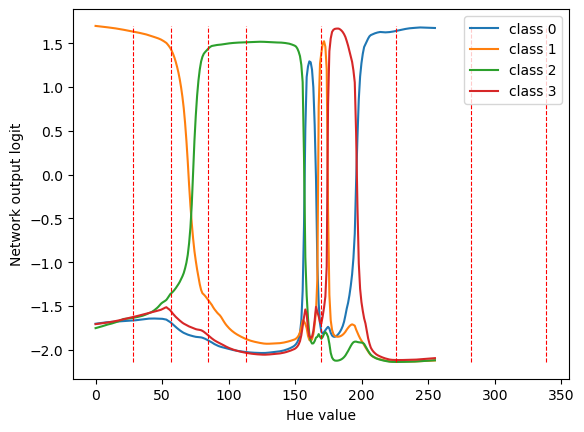

In [16]:
responses = np.arcsinh(np.array(responses))
for output_logit in range(responses.shape[1]):
    plt.plot(counterfactual_color_values, responses[:, output_logit], label=f"class {output_logit}")
plt.legend()
plt.xlabel("Hue value")
plt.ylabel("Network output logit")
plt.vlines(critical_color_values, np.min(responses), np.max(responses), linewidth=0.8,
           colors="r", label="decision boundary",
           linestyles="dashed") # with .eval() works well
# hue non-linear transformation could be messing it up, instead 

In [7]:
@torch.no_grad()
def finite_differences(model, dataset, target_class, stacked_img, locations, channel, unfairness, values_prior):
    num_iters = 15 # sample 15 values evenly spaced
    cuda_stacked_img = torch.tensor(stacked_img).to(device)
    if dataset.num_classes == 2:
        class_multiplier = 1 if target_class == 1 else -1 
        baseline_activations = class_multiplier*model(cuda_stacked_img, logits=True)
    else:
        baseline_activations = model(cuda_stacked_img)[:, target_class]
    largest_slope = np.zeros(stacked_img.shape[0])  # directional finite difference?
    slices = np.index_exp[np.arange(stacked_img.shape[0]), channel, locations[:, 0], locations[:, 1]]
    if values_prior is None:
        values_prior = np.linspace(5, 250, num_iters) # uniform distribution assumption
    elif isinstance(values_prior, list):
        values_prior = np.expand_dims(np.asarray(values_prior), 1)
    num_loops = 1 if unfairness == "very unfair" else len(values_prior)
    for i in range(num_loops):
        shift_img = stacked_img.copy()
        # shifting method
        if unfairness in ["fair", "unfair"]:
            shift_img[slices] = values_prior[i]-0.02  # add tiny offset to "guarantee" non-zero shift
        elif unfairness in ["very unfair"]:
            critical_value_dists = shift_img[slices] - values_prior
            closest = np.argmin(abs(critical_value_dists), axis=0) # find closest class boundary
            shift_img[slices] = 0.01 + np.choose(closest, values_prior) - 10*np.sign(np.choose(closest, critical_value_dists))
        
        actual_diffs = shift_img[slices] - stacked_img[slices]  
        img_norm = torch.tensor(shift_img).to(device) # best is no normalization anyway
        if dataset.num_classes == 2:
            activations = class_multiplier*model(img_norm, logits=True)
        else:
            activations = model(img_norm)[:, target_class]
        activation_diff = (activations - baseline_activations).cpu().numpy().squeeze()
        finite_difference = np.clip(activation_diff/actual_diffs, -30, 30) # take absolute slope
        largest_slope = np.where(abs(finite_difference) > abs(largest_slope), finite_difference, largest_slope)
    return largest_slope      

def finite_differences_map(model, dataset, target_class, img, unfairness="fair", values_prior=None):
    # generate a saliency map using finite differences method (iterate over colors)
    model.eval()
    batch_size = 32  # check batch_size num pixel positions in parallel
    im_size = dataset.size
    assert not isinstance(target_class, np.ndarray) # should be an index into output logits
    #img = img.astype(np.float32)/255. # normalization handled later
    values_x = np.repeat(np.arange(im_size), im_size)
    values_y = np.tile(np.arange(im_size), im_size)
    indices = np.stack((values_x, values_y), axis=1)
    stacked_img = np.repeat(np.expand_dims(img, 0), batch_size, axis=0)
    stacked_img = np.transpose(stacked_img, (0, 3, 1, 2)).astype(np.float32) # NCHW format
    img_heat_map = np.zeros_like(img)
    for channel in range(dataset.channels):
        for k in tqdm(range(0, im_size*im_size, batch_size)):
            actual_batch_size = min(batch_size, im_size*im_size-k+batch_size)
            locations = indices[k:k+batch_size]
            largest_slopes = finite_differences(model, dataset, target_class, stacked_img, locations, channel, unfairness, values_prior)
            img_heat_map[locations[:,0], locations[:,1], channel] = largest_slopes
    return img_heat_map.sum(axis=2)  # linear approximation aggregation?
# np.random.seed(500_001)
# explain_img, _, __ = valid_set.generate_one()
# heat_map = finite_differences_map(res_net, valid_set, 0, explain_img)

In [22]:
np.random.seed(500_001)
explain_img, explain_target_logit, __ = valid_set.generate_one()
heat_map = finite_differences_map(res_net, valid_set, explain_target_logit.argmax(), explain_img)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [08:39<00:00,  1.02s/it]


[0. 0. 0. 1.]


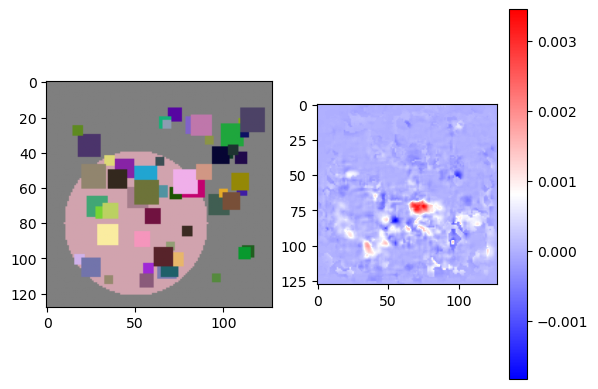

In [24]:
plt.subplot(1, 2, 1)
plt.imshow(explain_img/255.)
plt.subplot(1, 2, 2)
plt.imshow(heat_map, cmap="bwr", interpolation="bilinear")
plt.colorbar()
print(explain_target_logit)
# do 3 maps for each color channel, and also maybe do absolute values (might cancel each other)
# MAYBE DO CUBES OF COLOR CLASS, AND ALSO VISULAZIE WITH POINT CLOUD THE NETWORK LOGIT (CAN ONLY DO 1 CLASS, OR MAYBE DO MULTIPLE MAPS)
# probably better for getting step-function style stuff

In [9]:
#image_ids = #[20_000, 25_001, 30_000, 600_000, 600_001]
image_ids = [25_001]#, 30_000, 600_000, 600_001]
#heat_maps = []
plt.figure(figsize=(8, 5*len(image_ids)))
for i, image_id in enumerate(image_ids):
    np.random.seed(image_id)
    explain_img_i, target_i, __ = valid_set.generate_one()
    heat_map_i = finite_differences_map(res_net, valid_set, target_i.argmax(), explain_img_i)
    heat_maps.append(heat_map_i)
#     plt.subplot(len(image_ids), 2, 2*i+1)
#     plt.imshow(explain_img_i/255.)
#     plt.subplot(len(image_ids), 2, 2*i+2)
#     plt.imshow(heat_map_i, cmap="bwr", interpolation="bilinear")
#     plt.colorbar(shrink=0.5)
# plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [06:38<00:00,  1.29it/s]


NameError: name 'heat_maps' is not defined

<Figure size 800x500 with 0 Axes>

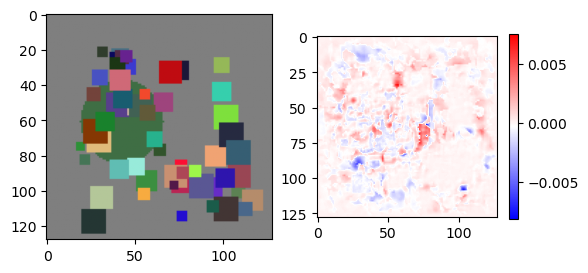

In [10]:
# image_ids = [20_000, 25_001]#, 30_000, 600_000, 600_001]
# #heat_maps = []
# plt.figure(figsize=(8, 5*len(image_ids)))
# for i, image_id in enumerate(image_ids):
np.random.seed(25_001)
explain_img_i, target_i, __ = valid_set.generate_one()
#heat_map_i = finite_differences_map(res_net, valid_set, target_i.argmax(), explain_img_i)
#heat_maps.append(heat_map_i)
plt.subplot(len(image_ids), 2, 2*i+1)
plt.imshow(explain_img_i/255.)
plt.subplot(len(image_ids), 2, 2*i+2)
plt.imshow(heat_map_i, cmap="bwr", interpolation="bilinear")
plt.colorbar(shrink=0.5)
#plt.show()

What if we run the same experiment, but cheat with a prior on pixel values that we know *should* be informative to the output logit, namely values closest to the decision boundary?

In [ ]:
unfair_prior = np.array([130, 140, 160, 170])  #  close to the critical value of 150

# Model Optimization Stuff

In [84]:
res_net.save_model_state_dict(optim=optim)

In [20]:
for _ in range(1000):
    res_net.forward(generated_img, profile=True)

In [21]:
total = sum(stats.values())  # --> gave 3x speed! (Fast and Accurate Model scaling?)
for k,v in stats.items():    # --> the 3x speedup caused underfitting though, so switched to 2x
    print(k,(100.*v/total))


forward-iter create 0.20726188370102722
forward-conv_bn_relu 0+1 2.7006421528858877
forward-conv_bn_relu 0+2 2.46820488389047
forward-is_resid 0 0.140192307181084
forward-conv_bn_relu 1+1 7.7374812862698406
forward-conv_bn_relu 1+2 7.666144324683222
forward-is_resid 1 0.800288543219722
forward-conv_bn_relu 2+1 3.1146057552987405
forward-conv_bn_relu 2+2 3.0776592523305655
forward-is_resid 2 0.14662447736729572
forward-conv_bn_relu 3+1 4.7860635998511984
forward-conv_bn_relu 3+2 4.776948196896868
forward-is_resid 3 0.4458012170567157
forward-conv_bn_relu 4+1 2.8268881864514457
forward-conv_bn_relu 4+2 2.754490443847031
forward-is_resid 4 0.14374684725033482
forward-conv_bn_relu 5+1 2.7202806749200072
forward-conv_bn_relu 5+2 2.6010979085685193
forward-is_resid 5 0.34566739955608067
forward-conv_bn_relu 6+1 2.6879107607363375
forward-conv_bn_relu 6+2 2.5640864766509917
forward-is_resid 6 0.1396393620568139
forward-conv_bn_relu 7+1 2.8555258848705014
forward-conv_bn_relu 7+2 2.83175361368